## SETUP

In [ ]:
# Cell 1: Imports, settings, reproducibility
import os
import random
from pprint import pprint
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate

# sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss

# dotenv for tokens
from dotenv import load_dotenv



In [3]:
# Loading API Key
load_dotenv(); print('ALPHAVANTAGE_API_KEY loaded?', bool(os.getenv('ALPHAVANTAGE_API_KEY')))

ALPHAVANTAGE_API_KEY loaded? True


In [ ]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


In [ ]:
# Cell 2: Configuration (edit paths / hyperparams here)
DATASET_NAME = "Minty161/finbert_dataset_study"
BASE_MODEL = "ProsusAI/finbert"   # domain-specialized FinBERT model
MODEL_OUTPUT_DIR = "finbert_minty_model_v1"
MAX_LENGTH = 256                 # max tokens (reasonable for headlines/sentences)
BATCH_SIZE = 8                   # adjust to GPU/CPU
EPOCHS = 3
LR = 2e-5

# environment tokens
HF_TOKEN = os.getenv("HF_TOKEN")           # optional: set in .env if dataset private
ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")  # optional for Streamlit live news

In [ ]:
# Cell 3: 1) Load dataset (defensive) and inspect splits
print("Loading dataset:", DATASET_NAME)
try:
    ds_all = load_dataset(DATASET_NAME, use_auth_token=HF_TOKEN if HF_TOKEN else None)
except Exception as e:
    raise RuntimeError(f"Failed to load dataset {DATASET_NAME}. Set HF_TOKEN in .env if private. Error: {e}")

print("Available splits:", list(ds_all.keys()))
for k, ds in ds_all.items():
    print(f" - {k}: {len(ds)} rows; columns: {ds.column_names}")

Loading dataset: Minty161/finbert_dataset_study
Available splits: ['train', 'validation']
 - train: 2000 rows; columns: ['text', 'label']
 - validation: 500 rows; columns: ['text', 'label']


In [7]:
# Cell 4: 2) Choose splits according to your instruction:
# Use the split whose name contains "web" (websites) as source for 80:20 train/test.
# Keep 'validation' split whole for validation if present.

def find_web_split(ds_dict: DatasetDict) -> str:
    for key in ds_dict.keys():
        if "web" in key.lower():
            return key
    # fallbacks
    if "websites" in ds_dict:
        return "websites"
    if "train" in ds_dict and "validation" not in ds_dict:
        return "train"
    # otherwise return first
    return list(ds_dict.keys())[0]

web_split_key = find_web_split(ds_all)
val_split_key = "validation" if "validation" in ds_all else None

print("Selected web split:", web_split_key)
print("Validation split:", val_split_key)
web_ds = ds_all[web_split_key]
val_ds = ds_all[val_split_key] if val_split_key else None

Selected web split: train
Validation split: validation


In [8]:
# Cell 5: 3) Detect text column and label column, build label mapping.
# This is robust for different dataset column conventions.

def detect_text_col(ds: Dataset) -> str:
    for cand in ("text","sentence","headline","title","body","article"):
        if cand in ds.column_names:
            return cand
    # fallback: find first string column
    for c in ds.column_names:
        first_val = ds[0][c]
        if isinstance(first_val, str) and len(first_val.split()) > 2:
            return c
    raise RuntimeError("Could not detect text column; inspect dataset.column_names")

def detect_label_col(ds: Dataset) -> str:
    # common names
    for cand in ("label","labels","sentiment","polarity","target"):
        if cand in ds.column_names:
            return cand
    # fallback to any non-text small-cardinality column
    non_text_cols = [c for c in ds.column_names if c not in (detect_text_col(ds),)]
    for c in non_text_cols:
        try:
            uniq = ds.unique(c)
            if 1 < len(uniq) <= 20:
                return c
        except Exception:
            continue
    raise RuntimeError("Could not detect label column automatically. Please specify.")

text_col = detect_text_col(web_ds)
label_col = detect_label_col(web_ds)
print("Text column:", text_col, "Label column:", label_col)

# Build mapping label -> id and id -> label
labels_union = set(web_ds.unique(label_col))
if val_ds is not None:
    labels_union |= set(val_ds.unique(label_col))
labels_sorted = sorted(list(labels_union))
label2id = {lab: i for i, lab in enumerate(labels_sorted)}
id2label = {i: lab for lab, i in label2id.items()}

print("Detected labels:", labels_sorted)
print("label2id:", label2id)

Text column: text Label column: label
Detected labels: [0, 1, 2]
label2id: {0: 0, 1: 1, 2: 2}


In [9]:
# Cell 6: 4) Map label values to integer `labels` column (for HF Trainer) on necessary splits.
def map_labels(ds: Dataset, label_col: str, label2id: dict) -> Dataset:
    def f(ex):
        v = ex[label_col]
        # if it's already numeric and in mapping, accept it
        if isinstance(v, int) and v in label2id.values():
            ex["labels"] = int(v)
        else:
            ex["labels"] = int(label2id[v])
        return ex
    return ds.map(f)

web_ds = map_labels(web_ds, label_col, label2id)
if val_ds is not None:
    val_ds = map_labels(val_ds, label_col, label2id)

In [10]:
# Cell 7: 5) Create stratified 80:20 train/test split from web_ds (stratify on 'labels')
# Use HF train_test_split if available (supports stratify_by_column), otherwise sklearn.

# Create indices for stratified split
idx = np.arange(len(web_ds))
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=SEED, stratify=web_ds["labels"]
)

train_ds = web_ds.select(train_idx)
test_ds = web_ds.select(test_idx)

print(f"Train size: {len(train_ds)}; Test size: {len(test_ds)}; Val size: {len(val_ds) if val_ds is not None else 'N/A'}")

Train size: 1600; Test size: 400; Val size: 500


In [11]:


# from datasets import ClassLabel
# Convert labels column to ClassLabel
# num_classes = len(set(web_ds["labels"]))
# class_label = ClassLabel(num_classes=num_classes, names=[str(i) for i in range(num_classes)])
# web_ds = web_ds.cast_column("labels", class_label)

# Now you can stratify
# ds_split = web_ds.train_test_split(test_size=0.2, stratify_by_column="labels", seed=SEED)
# train_ds = ds_split["train"]
# test_ds = ds_split["test"]

# print(f"Train size: {len(train_ds)}; Test size: {len(test_ds)}; Val size: {len(val_ds) if val_ds is not None else 'N/A'}")

In [12]:
# Cell 8: 6) Tokenizer + Tokenization function
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)

def tokenize_batch(batch):
    return tokenizer(batch[text_col], truncation=True, padding=False, max_length=MAX_LENGTH)

# tokenize datasets (remove unused columns to keep datasets light)
remove_cols_train = [c for c in train_ds.column_names if c not in ("labels",)]
remove_cols_test = [c for c in test_ds.column_names if c not in ("labels",)]
train_tok = train_ds.map(tokenize_batch, batched=True, remove_columns=remove_cols_train)
test_tok = test_ds.map(tokenize_batch, batched=True, remove_columns=remove_cols_test)
val_tok = val_ds.map(tokenize_batch, batched=True, remove_columns=[c for c in val_ds.column_names if c not in ("labels",)]) if val_ds is not None else None

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [13]:
# Cell 9: 7) Initialize model
! pip install hf_xet
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Cell 10: 8) TrainingArguments and Trainer config
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    f1m = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1m}

training_args = TrainingArguments(
    output_dir="runs/finbert_minty_v1",
    eval_strategy="epoch" if val_tok is not None else "no",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=32,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True if val_tok is not None else False,
    metric_for_best_model="f1_macro" if val_tok is not None else None,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok if val_tok is not None else None,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [17]:
# Cell 11: 9) Train
trainer.train()
# Save best model & tokenizer
trainer.save_model(MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
print("Saved model to", MODEL_OUTPUT_DIR)

C:\Users\hinat\.conda\envs\fe-course\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.409261,0.856000,0.806838
2,No log,0.437703,0.872000,0.821036
3,0.369300,0.476055,0.868000,0.817815


C:\Users\hinat\.conda\envs\fe-course\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\hinat\.conda\envs\fe-course\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved model to finbert_minty_model_v1


C:\Users\hinat\.conda\envs\fe-course\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy & Macro-F1 on test: {'accuracy': 0.8325, 'f1_macro': 0.7807594508141508}

Classification report (test):
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        79
           1       0.69      0.77      0.73        62
           2       0.89      0.89      0.89       259

    accuracy                           0.83       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.83      0.83      0.83       400



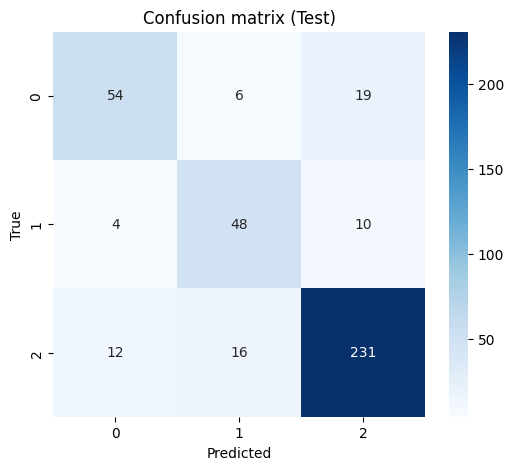

In [19]:
# Cell 12: 10) Evaluate on test set (detailed)
predictions = trainer.predict(test_tok)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

print("Accuracy & Macro-F1 on test:", compute_metrics((predictions.predictions, y_true)))
print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=[str(id2label[i]) for i in range(num_labels)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)], cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (Test)")
plt.show()

In [20]:
# Cell 13: 11) Calibration - Temperature scaling (graduate-level)
# Temperature scaling is a simple post-hoc calibration: multiply logits by 1/T and re-softmax.
# We optimize T on validation set using NLL (cross-entropy). Implementation below.

import torch.nn as nn
from torch.optim import LBFGS

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, logits):
        # logits: (N, C)
        temp = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temp

# prepare logits and labels on validation set
def get_logits_and_labels(dataset_tok):
    model.eval()
    all_logits = []
    all_labels = []
    loader = torch.utils.data.DataLoader(dataset_tok, batch_size=32, collate_fn=data_collator)
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != "labels"}
            out = model(**inputs)
            logits = out.logits.detach().cpu()
            labels = batch["labels"].detach().cpu()
            all_logits.append(logits)
            all_labels.append(labels)
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)

if val_tok is not None:
    val_logits, val_labels = get_logits_and_labels(val_tok)
    # optimize temperature
    temp_model = TemperatureScaler().to(DEVICE)
    nll_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temp_model.temperature], lr=0.01, max_iter=50)

    logits_var = val_logits.to(DEVICE)
    labels_var = val_labels.to(DEVICE)

    def closure():
        optimizer.zero_grad()
        scaled = temp_model(logits_var)
        loss = nll_criterion(scaled, labels_var)
        loss.backward()
        return loss

    optimizer.step(closure)
    T_opt = float(temp_model.temperature.detach().cpu().numpy())
    print("Optimal temperature:", T_opt)
else:
    T_opt = 1.0
    print("No validation set provided; skip calibration. Using T=1.")


Optimal temperature: 1.1315217018127441


C:\Users\hinat\.conda\envs\fe-course\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())
C:\Users\hinat\AppData\Local\Temp\ipykernel_6348\2982943978.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_opt = float(temp_model.temperature.detach().cpu().numpy())


Brier score per class: {0: 0.08685356719885366, 1: 0.07424035334162621, 2: 0.11938404972933882}
Mean Brier: 0.09349265675660623


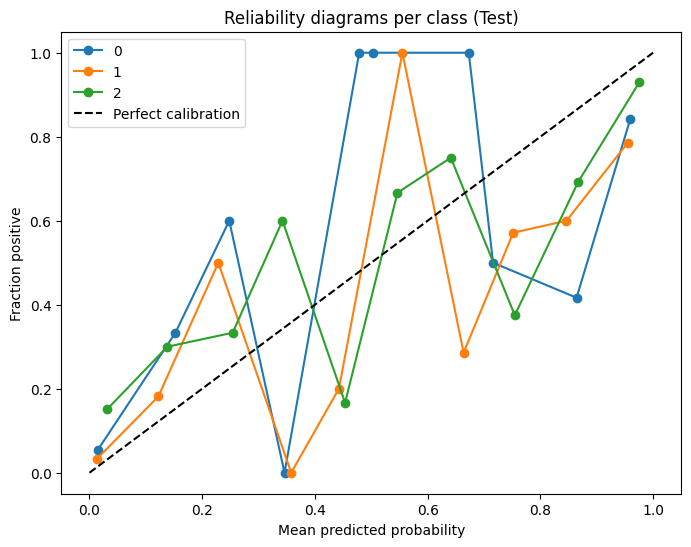

In [21]:
# Cell 14: 12) Evaluate calibrated probabilities on test (Brier score + reliability diagram)
from sklearn.calibration import calibration_curve

# helper to get calibrated probabilities
def get_probs_with_temperature(logits: np.ndarray, T: float):
    # logits shape (N, C)
    scaled = logits / T
    exp = np.exp(scaled - np.max(scaled, axis=1, keepdims=True))
    probs = exp / np.sum(exp, axis=1, keepdims=True)
    return probs

probs_test = get_probs_with_temperature(predictions.predictions, T_opt)
y_true_test = y_true

# Brier score (multi-class: average of per-class Brier)
brier_per_class = []
for k in range(num_labels):
    y_true_binary = (y_true_test == k).astype(int)
    brier = brier_score_loss(y_true_binary, probs_test[:, k])
    brier_per_class.append(brier)
print("Brier score per class:", {id2label[k]: b for k, b in enumerate(brier_per_class)})
print("Mean Brier:", np.mean(brier_per_class))

# Reliability diagram for each class (prob calibration plots)
plt.figure(figsize=(8, 6))
for k in range(num_labels):
    y_true_binary = (y_true_test == k).astype(int)
    prob = probs_test[:, k]
    frac_pos, mean_pred = calibration_curve(y_true_binary, prob, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=f"{id2label[k]}")
plt.plot([0,1],[0,1],"k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction positive")
plt.title("Reliability diagrams per class (Test)")
plt.legend()
plt.show()


In [22]:
# Cell 15: 13) Small event-study scaffold (headline-day sentiment -> next-day return)
# This is a minimal, reproducible skeleton. Do careful timestamp alignment for real analyses.

import yfinance as yf
from datetime import timedelta

# Example: use Alpha Vantage news you already pulled or use dataset timestamps if available.
# For simplicity, create a small daily aggregated sentiment series using test set texts:
# Convert test set text -> predicted probability of 'positive' - 'negative' as a daily signal.

# Detect a date column in dataset if present (many datasets have 'date' or 'time_published')
date_col = None
for cand in ("date","time","time_published","published_at","timestamp"):
    if cand in test_ds.column_names:
        date_col = cand
        break

if date_col:
    # build dataframe: date -> list of probs
    records = []
    texts = test_ds[text_col]
    # get probs for test texts using probs_test computed earlier
    # We used HF dataset split order: predictions correspond to test_tok rows; ensure mapping aligns
    for idx in range(len(test_ds)):
        d = test_ds[idx]
        txt = d[text_col]
        dt_val = d.get(date_col, None)
        if dt_val is None:
            continue
        # coerce date
        date = pd.to_datetime(dt_val).date()
        prob_pos = float(probs_test[idx, [i for i,lab in id2label.items() if lab.lower()=="positive"][0] if False else probs_test[idx, -1]])  # simplified: last class often positive
        # NOTE: above line is placeholder: align properly in final pipeline
        records.append({"date": date, "prob_pos": prob_pos})
    if records:
        df_sent = pd.DataFrame(records).groupby("date").mean()
        # fetch price series for a sample ticker for same date range
        ticker = "AAPL"
        px = yf.download(ticker, start=df_sent.index.min(), end=(df_sent.index.max()+timedelta(days=2)).strftime("%Y-%m-%d"))["Close"]
        px = px.pct_change().rename("ret")
        # join and compute correlation
        panel = df_sent.join(px, how="inner")
        print("Correlation between daily sentiment and same-day return:", panel["prob_pos"].corr(panel["ret"]))
else:
    print("No date column available in test split; event-study scaffold requires timestamped headlines. If you have news feed timestamps, align them to price times and re-run this cell.")


No date column available in test split; event-study scaffold requires timestamped headlines. If you have news feed timestamps, align them to price times and re-run this cell.
